In [7]:
from pathlib import Path

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import sys

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
#import plotly.express as px

# external_path = Path("/Users/ylin/My Drive/Cohost/Data and Reporting/Codes/python/")
# sys.path.append(str(external_path))
# from DataProcessing import import_data,property_input,format_reservation

def load_data() -> pd.DataFrame:
    """
    Load and merge property, cleaning, and bookings data.

    Assumptions (align with your R code):
    - data/Property_Cohost.xlsx has:
        * Sheet 0: property details (Listing, PropertyType, Region, OCCUPANCY, SqFt, BEDROOMS, BEDS, BATHROOMS)
        * Sheet "Cleaning": cleaning fees (Listing, Group, Cleaner.lead, Cleaning.fee)
    - data/bookings.csv OR data/bookings.xlsx has:
        * Listing
        * checkout_date
        * AvgDailyRate
        * guests
    """
    #bookings = import_data()
    filepath = "/Users/ylin/Google Drive/My Drive/Cohost/Cohost Cleaner Compensation/Working/Data/"
    property = pd.read_excel(filepath+"Property_Cohost.xlsx")
    cleaner = pd.read_excel(filepath+"Property_Cohost.xlsx",sheet_name="Cleaning")

    data = property[['Listing', "Type","Status",'PropertyType','Region','MaxGuests', 
        'SqFt', 'BEDROOMS', 'BEDS', 'BATHROOMS']].merge(cleaner[['Listing','Group',
        'Cleaner lead','Cleaning.fee',"PropertyClass"]], on="Listing",how="outer")
    data = data.loc[(data["Cleaning.fee"].notna()) &(data["SqFt"].notna()) &(data["MaxGuests"].notna())]
    data["hottub"]=np.where(data["Listing"].isin(["Lilliwaup 28610", "Shelton 310", "Shelton 250", 
                                            "Hoodsport 26060", "Longbranch 6821", "Poulsbo 3956"]),"Yes","No")
    data["PropertyType"] = np.where(data["PropertyType"].isin(["Guest suite","Guesthouse"]),"Guesthouse_ADU",data["PropertyType"])

    # Guests = (bookings[(bookings["checkout_date"]>=pd.to_datetime("2024-01-01"))]
    # .groupby("Listing")
    # .agg(avg_bookings_per_month=("Confirmation.Code","nunique"),
    #     med_rate = ("AvgDailyRate","median"),
    #     avg_rate_per_guest =("AvgDailyRate",
    #             lambda x: (x / bookings.loc[x.index, "guests"]).mean(),
    #         ),
    #     avg_guest = ("guests","mean"),
    #     med_guest =("guests","median")))
    # Guests["avg_bookings_per_month"] = Guests["avg_bookings_per_month"] /21

    # data = data.merge(Guests,on="Listing",how="left")
    mask = (data["Listing"].isin(["Cottages All OSBR"])) # |(data["avg_bookings_per_month"].isna())
    data = data[~mask]
    return data

model = joblib.load("../models/cleaning_fee_rf.pkl")

In [8]:
# -----------------------------
# CONFIG: feature lists
# -----------------------------
NUMERIC_FEATURES = [
    "MaxGuests",
    "SqFt",
    "BEDROOMS",
    "BEDS",
    "BATHROOMS",
    #"med_guest",
    #"avg_bookings_per_month",
    #"avg_rate",
    #"avg_rate_per_guest",
]

CATEGORICAL_FEATURES = [
    "hottub",
    "PropertyType",
    "Region",
    "PropertyClass",
]


In [25]:
def get_aggregated_importances(
    model,
    numeric_features,
    categorical_features,
):
    """
    Compute feature importances aggregated back to original features
    (numeric + categorical), even when the model is a Pipeline with
    a ColumnTransformer + OneHotEncoder.

    Returns:
        agg_names: list of original feature names
        agg_importances: np.array of same length
    """

    # 1) Extract RF and preprocessor from pipeline
    if not hasattr(model, "named_steps"):
        raise ValueError(
            "Expected a Pipeline with steps 'preprocess' and 'rf'. "
            "Got: {}".format(type(model))
        )

    rf = model.named_steps["rf"]
    preprocessor = model.named_steps["preprocess"]

    importances = rf.feature_importances_

    # 2) Build list of transformed feature names in the same order RF sees them
    #    Our ColumnTransformer has two transformers: ("num", ..., numeric_features) and ("cat", OneHotEncoder, categorical_features)
    ct = preprocessor

    # Numeric: 'passthrough' preserves order, one col per original numeric feature
    transformed_feature_names = []
    for f in numeric_features:
        transformed_feature_names.append(f)

    # Categorical: get dummy names from the fitted OneHotEncoder
    ohe = ct.named_transformers_["cat"]
    # This returns names like 'PropertyType_Condominium', 'Region_Seattle', etc.
    ohe_feature_names = ohe.get_feature_names_out(categorical_features)
    transformed_feature_names.extend(ohe_feature_names)

    if len(transformed_feature_names) != len(importances):
        raise ValueError(
            f"Length mismatch: {len(transformed_feature_names)} transformed "
            f"features vs {len(importances)} importances."
        )

    # 3) Aggregate importances back to original features
    agg = {f: 0.0 for f in numeric_features + categorical_features}

    for name, imp in zip(transformed_feature_names, importances):
        if name in numeric_features:
            # Numeric feature: one-to-one
            agg[name] += float(imp)
        else:
            # One-hot feature, e.g. 'PropertyType_Condominium'
            # Split on first underscore to recover original feature name
            orig = name.split("_", 1)[0]
            if orig in agg:
                agg[orig] += float(imp)

    agg_names = list(agg.keys())
    agg_importances = np.array([agg[n] for n in agg_names])

    return agg_names, agg_importances

def plot_feature_importance_aggregated(
    model,
    numeric_features,
    categorical_features,
    #out_path: Path,
):
    """
    Similar to varImpPlot(rf_cv$finalModel) in R,
    but aggregated to original feature level.
    """
    
    feature_names, agg_importances = get_aggregated_importances(
    model,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
)
    
    # Sort descending
    idx = np.argsort(agg_importances)
    sorted_names = [feature_names[i] for i in idx]
    sorted_importances = agg_importances[idx]

    plt.figure(figsize=(6, 4))
    plt.barh(sorted_names, sorted_importances)
    plt.xticks(rotation=0)
    plt.yticks(range(len(sorted_names)), sorted_names)
    plt.title("Random Forest Feature Importance (by original feature)")
    plt.tight_layout()
    #plt.savefig(out_path, dpi=150)
    #plt.close()

def plot_partial_dependence(model, X: pd.DataFrame, col_sel,
                                  #out_path: Path
                                  ):
    """
    Partial dependence for SqFt, similar to:
      p1 <- partial(rf_cv, pred.var = "SqFt", train = data)
      autoplot(..., rug = TRUE)
    """
    fig, ax = plt.subplots(figsize=(6, 4))

    # PDP
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=[col_sel],
        ax=ax,
    )

    # Add rug for SqFt values along x-axis
    sqft_vals = X[col_sel].values
    # Put rug slightly below the plot's minimum PDP value
    ymin, ymax = ax.get_ylim()
    rug_y = ymin - 0.02 * (ymax - ymin)
    ax.plot(sqft_vals, np.full_like(sqft_vals, rug_y), "|", markersize=4)

    ax.set_title("Partial Dependence: "+ col_sel)
    plt.tight_layout()
    #plt.savefig(out_path, dpi=150)
    #plt.close()

def plot_pdp_categorical(model, X: pd.DataFrame, feature: str):
    """
    Manual partial dependence for a categorical feature.
    For each category, replace the feature with that category
    and compute mean prediction.
    """
    # Unique categories
    categories = X[feature].dropna().unique()
    categories = np.sort(categories)

    pd_values = []

    for cat in categories:
        X_copy = X.copy()
        X_copy[feature] = cat          # set everyone to this category
        preds = model.predict(X_copy)
        pd_values.append(preds.mean())

    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(range(len(categories)), pd_values)
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha="right")
    ax.set_ylabel("Partial Dependence (mean prediction)")
    ax.set_title(f"Partial Dependence: {feature}")
    plt.tight_layout()
    plt.show()


In [12]:
df = load_data()
#df["PropertyClass"] = np.where(df["med_rate"]<180,"Economy",np.where((df["med_rate"]>=250)&(df["BEDROOMS"]>3),"Luxury","Middle"))
#groups = df.groupby("PropertyClass")["Listing"].apply(list).reset_index()
#print(groups)

In [13]:
df = load_data()
df_model = df.dropna(
    subset=NUMERIC_FEATURES + CATEGORICAL_FEATURES + ["Cleaning.fee"]
).copy()
X_for_fit = df_model[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
df["fitted_value"] = np.ceil(model.predict(X_for_fit))
df["fitted_value"] = np.where(df["fitted_value"]<df["Cleaning.fee"],df["Cleaning.fee"],df["fitted_value"])
df["fitted_value_increase_5%"] = np.ceil(df["fitted_value"]*1.03)
df["incr"] = (df["fitted_value"] - df["Cleaning.fee"])/df["Cleaning.fee"]
df["incr5"] = (df["fitted_value_increase_5%"] - df["Cleaning.fee"])/df["Cleaning.fee"]

In [23]:
df.to_excel("/Users/ylin/My Drive/Cohost/Data and Reporting/05-Cleaning/CleaningModelApp/data/Cleaning_fee_estimates.xlsx",index=False)

In [16]:
df[["incr","incr5"]].describe()

,incr,incr5
count,89.000000,89.000000
mean,0.019021,0.053270
std,0.028610,0.030846
min,0.000000,0.030000
25%,0.000000,0.031579
50%,0.000000,0.037037
75%,0.022222,0.066667
max,0.118750,0.156250


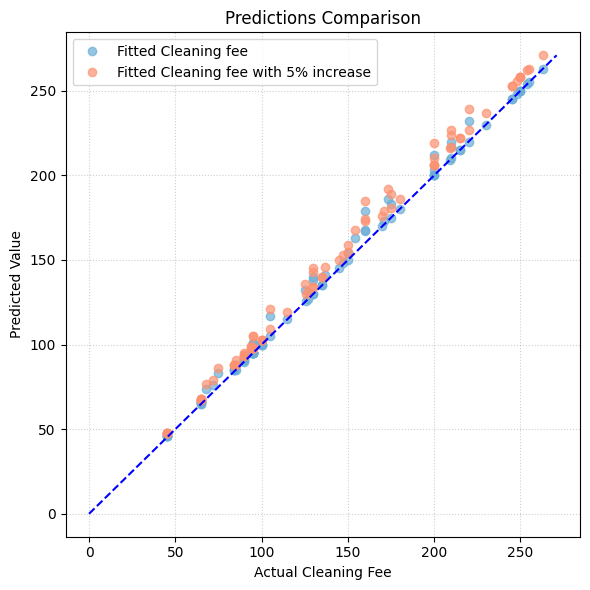

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# updated_value
plt.plot(
    df["Cleaning.fee"],
    df["fitted_value"],
    "o",              # points only (like geom_point)
    color="#6BAED6",
    label="Fitted Cleaning fee",
    alpha=0.7
)

# updated_value_5
plt.plot(
    df["Cleaning.fee"],
    df["fitted_value_increase_5%"],
    "o",              # points only
    color="#FC9272",
    label="Fitted Cleaning fee with 5% increase", alpha=0.7
)

# 1:1 line
max_val = max(df["Cleaning.fee"].max(), df["fitted_value_increase_5%"].max())
plt.plot([0, max_val], [0, max_val], "b--")

plt.xlabel("Actual Cleaning Fee")
plt.ylabel("Predicted Value")
plt.title("Predictions Comparison")

plt.grid(True, linestyle="dotted", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

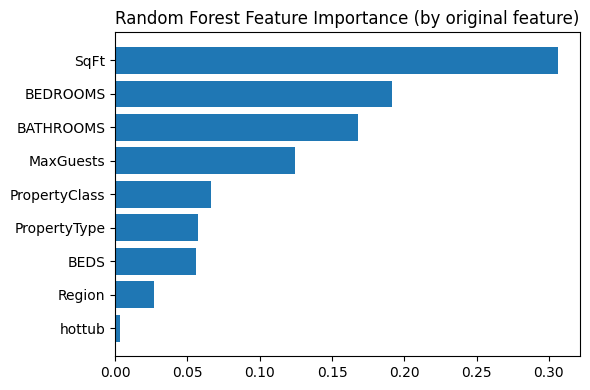

In [18]:
plot_feature_importance_aggregated(model, NUMERIC_FEATURES,CATEGORICAL_FEATURES)

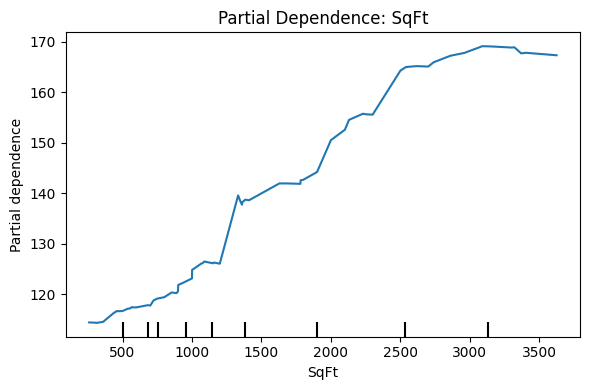

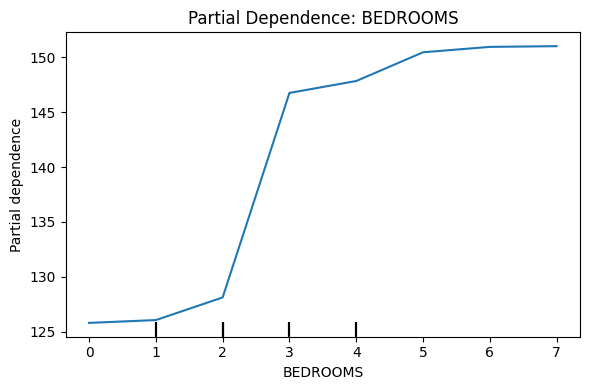

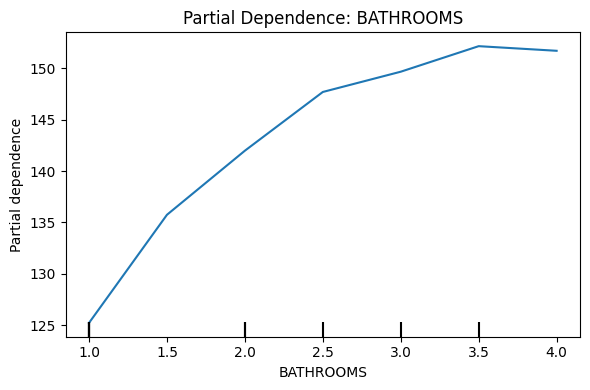

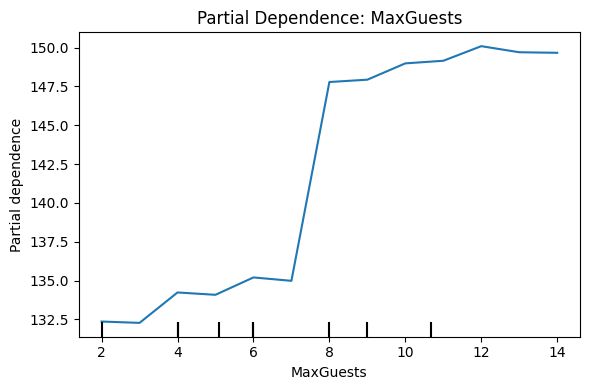

In [19]:
plot_partial_dependence(model, X_for_fit, "SqFt")
plot_partial_dependence(model, X_for_fit, "BEDROOMS")
plot_partial_dependence(model, X_for_fit, "BATHROOMS")
plot_partial_dependence(model, X_for_fit, "MaxGuests")


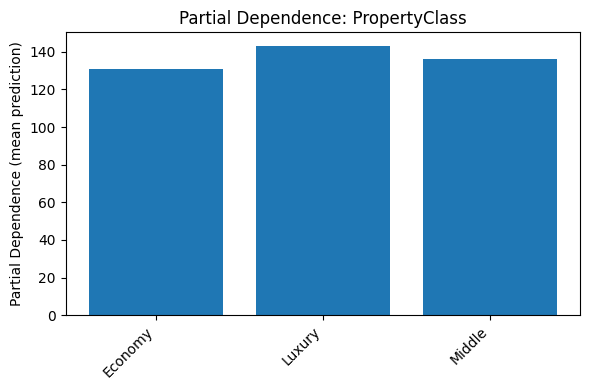

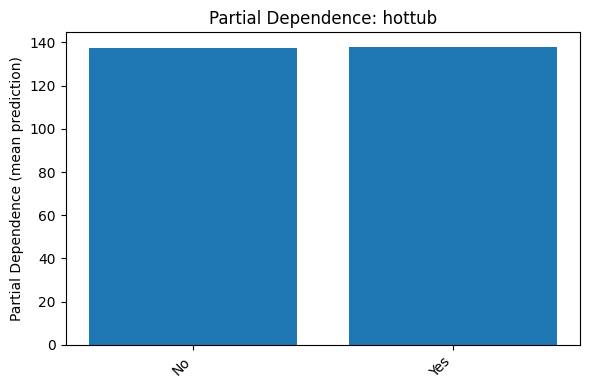

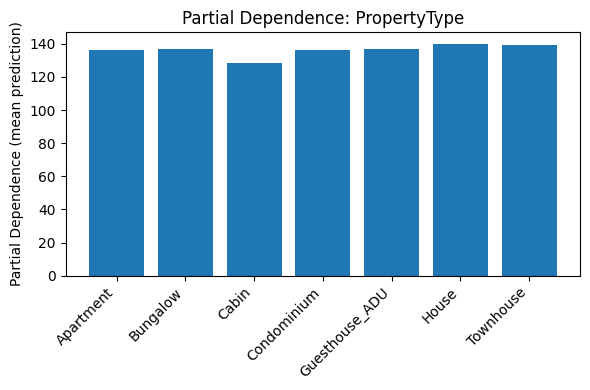

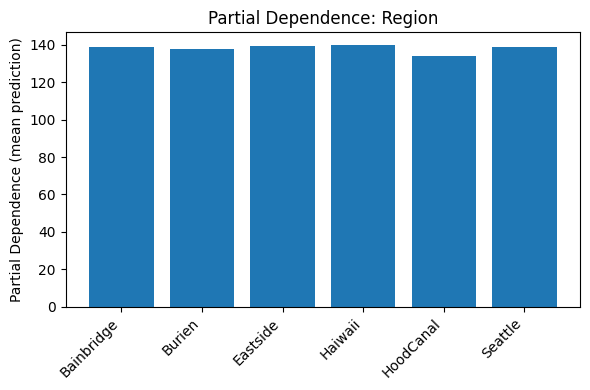

In [28]:
## plot 
plot_pdp_categorical(model, X_for_fit, "PropertyClass")
plot_pdp_categorical(model, X_for_fit, "hottub")
plot_pdp_categorical(model, X_for_fit, "PropertyType")
plot_pdp_categorical(model, X_for_fit, "Region")